In [1]:
import pickle
try:
    import ase.db
except ImportError:
    print("ase db not installed, will not connect to c2db.db.")

print("Collecting type III heterojunctions...")

def candidate(left, right):
    # Apply attr to each combination of band energies with given suffix
    def calculation(attr, suffix): return (
        attr(row,band)
            for row in (left,right)
            for band in ('vbm'+suffix,'cbm'+suffix)
    )

    # Check that a is in ascending order
    def ascending(a): return all(
        a[i]<a[i+1] for i in range(len(a)-1)
    )

    # Only compare bands calculated with the same functional, prefer GW > HSE > PBE
    for (functional,suffix) in (('GW','_gw'),('HSE','_hse'),('PBE','')):
        if all(calculation(hasattr,suffix)):
            lvbm,lcbm,rvbm,rcbm = calculation(getattr,suffix)
            lvbm,lcbm,rvbm,rcbm = ( # Center bands on evac=0
                lvbm - left.evac,
                lcbm - left.evac,
                rvbm - right.evac,
                rcbm - right.evac
            )
            if all((
                functional != 'PBE', # Do not accept PBE functionals
                getattr(left,'class',None) == getattr(right,'class',None), # Materials must have the same phase
                left.spgnum == right.spgnum, # Materials must have the same space group
                ascending((lvbm,lcbm,rvbm,rcbm)) # Gap is broken and bands are rising 
            )):
                return (
                    left.formula,                   #0
                    left.uid,                       #1
                    lvbm,                           #2
                    lcbm,                           #3
                    right.formula,                  #4
                    right.uid,                      #5
                    rvbm,                           #6
                    rcbm,                           #7
                    functional,                     #8
                    getattr(left,'class',None),     #9
                    left.spacegroup,                #10
                    rcbm - lvbm,                    #11
                    left.cell_area/right.cell_area  #12
                )

headers = [     # The title of each candidate entry
    'Left',     #0
    'uid',      #1
    'vbm',      #2
    'cbm',      #3
    'Right',    #4
    'uid',      #5
    'vbm',      #6
    'cbm',      #7
    'Calc',     #8
    'Class',    #9
    'Group',    #10
    'ΔE',       #11
    'R'         #12
]

try:
    with open('./typeIII.pickle','rb') as pk:
        typeIII = pickle.load(pk)
        print("Loaded from pickle.")
except (OSError, IOError):
    # Connect to database
    db = ase.db.connect('c2db.db')
    # Find rows that have a vacuum energy, space group number, high thermodynamic stability, and are not magnetic
    rows = list(db.select('evac,spgnum,thermodynamic_stability_level=3,is_magnetic=0'))
    # Find pairs of rows that could be type III heterojunctions
    typeIII = sorted(
        filter(
            None.__ne__, # Remove results that were not candidates
            [candidate(l,r) for l in rows for r in rows] # Take every pair in the selection
        ),
        key = lambda t: t[12] if 1 <= t[12] else 1/t[12] # Sort by how close R is to 1
    )
    print("Loaded from ase db.")
    with open('./typeIII.pickle','wb') as pk: # Cache results to make plot changes load faster
        pickle.dump(typeIII, pk)
        print("Dumped to pickle.")

ase db not installed, will not connect to c2db.db.
Loaded from pickle.


In [2]:
import pandas as pd
from tabulate import tabulate

spgs = pd.unique([t[10] for t in typeIII]) # Find which space groups we found pairs from
print("Collected " + str(len(typeIII)) + " type III heterojunctions from " + str(len(spgs)) + " space groups:")

best = [next(filter(lambda t: t[10] == spg, typeIII)) for spg in spgs] # The best pair from each spacegroup
print()
print(tabulate(best, headers)) # Print out a table of the best pairs

Collected 2510 type III heterojunctions from 20 space groups:

Left        uid                           vbm       cbm  Right       uid                           vbm       cbm  Calc    Class      Group          ΔE         R
----------  -----------------------  --------  --------  ----------  -----------------------  --------  --------  ------  ---------  -------  --------  --------
Cu4Cl4O4    Cl4Cu4O4-2cd6237bcf01    -8.82381  -7.58707  Pt2Se4      Pt2Se4-60c67ebd5bd2      -6.06715  -3.77011  HSE                P2_1/c   5.05371   1.00021
Bi2Se3      Bi2Se3-709937cca934      -6.33619  -5.58413  OSb2Te2     OSb2Te2-48bbacdd20ba     -5.1722   -4.18673  HSE                P1       2.14947   0.99978
ZrSSe       SSeZr-2be14f373da0       -7.35997  -5.15447  ZrClI       ClIZr-73202b4b7837       -4.07284  -2.32869  GW      MXY Janus  P3m1     5.03128   1.00042
Hg2Se2      Hg2Se2-f2919d1605f0      -6.09644  -5.80772  In2I2       I2In2-9ab97b2e26fc       -5.72337  -4.38874  HSE                P-

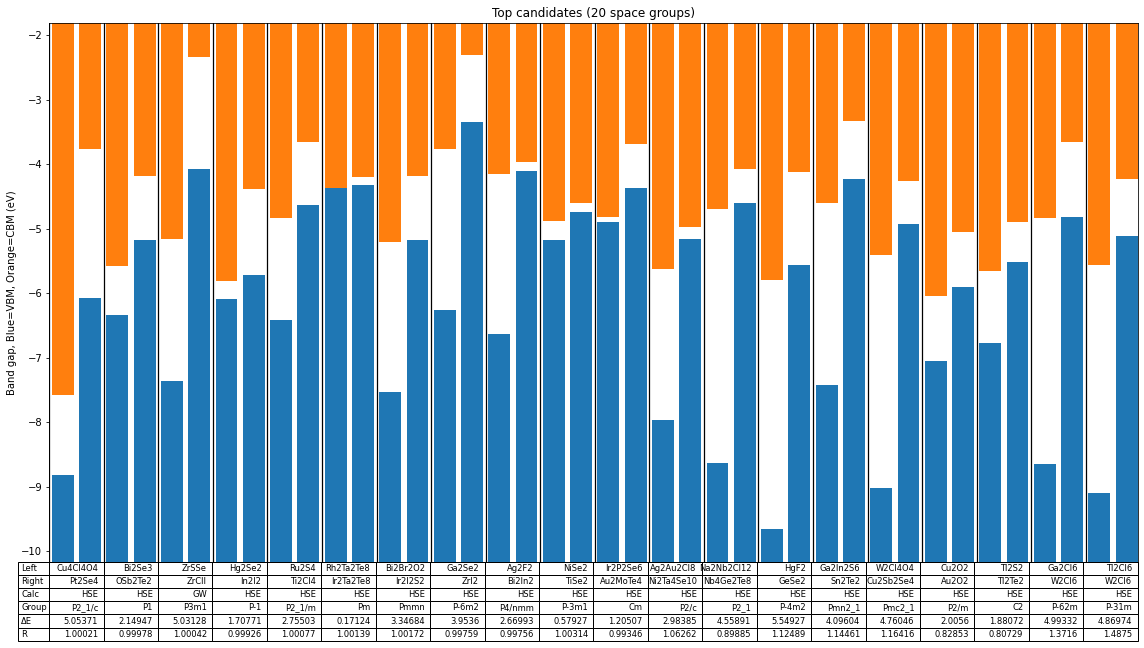

In [3]:

import numpy as np
import matplotlib.pyplot as plt

table_headers_indices = [0,4,8,10,11,12] # Which headers to display in the table

def bands_with_table(pairs): # Plot each pair of candidates, with bars for the band gaps, and a table for other stats
    ax = plt.subplot(label=str(id(pairs)))
    ax.margins(x=0)

    flatx = range(len(pairs)*2)

    if(flatx == range(0)):
        return

    leftvbm = np.array([t[2] for t in pairs])
    leftcbm = np.array([t[3] for t in pairs])
    emin = np.amin(leftvbm) - .5

    rightvbm = np.array([t[6] for t in pairs])
    rightcbm = np.array([t[7] for t in pairs])
    emax = np.amax(rightcbm) + .5

    leftx = flatx[::2]
    ax.bar(leftx, leftvbm-emin, bottom=emin, color='C0')
    ax.bar(leftx, leftcbm-emax, bottom=emax, color='C1')
    #ax.bar(leftx, leftvbm-leftcbm, bottom=leftcbm)

    rightx = flatx[1::2]
    ax.bar(rightx, rightvbm-emin, bottom=emin)
    ax.bar(rightx, rightcbm-emax, bottom=emax)
    #ax.bar(rightx, rightvbm-rightcbm, bottom=rightcbm)

    ax.set_ylim(emin,emax)

    plt.xticks([],[])

    table = plt.table(
        cellText = [
            [ t[i] if not isinstance(t[i], float) else round(t[i],5) for t in pairs ]
                for i in table_headers_indices
        ],
        rowLabels=[headers[i] for i in table_headers_indices],
        loc='bottom',
        picker=True # Table is clickable
    )
    table.auto_set_font_size(False)
    table.set_fontsize('small')

    plt.axhline(0, linewidth=.75, color='k')

    for v in leftx:
        plt.axvline(v-.5, linewidth=1.25, color='k')

    plt.ylabel('Band gap, Blue=VBM, Orange=CBM (eV)')

plt.figure(figsize=(16,9))
bands_with_table(best)
plt.title("Top candidates (" + str(len(spgs)) + " space groups)")
plt.tight_layout()

plt.show()

In [5]:
from IPython.display import display
import ipywidgets as widgets

ddown = widgets.Dropdown(
    options=spgs,
    description='Space group:',
    style={'description_width': 'initial'}
)

spacegroup = None
def selected(row):
    global spacegroup
    spacegroup = [t for t in typeIII if t[10] == ddown.value] # Rows in this group
ddown.observe(selected, names='value')
selected(None)

slide = widgets.IntRangeSlider(
    value=(0,20),
    description='Candidate indices:',
    style={'description_width': 'initial'},
    disabled=False
)

def selected_max(row):
    slide.max = len(spacegroup)
    upper = min(slide.value[1],slide.max)
    lower = min(slide.value[0],upper)
    slide.value = (lower,upper)
ddown.observe(selected_max, names='value')
selected_max(None)

bands = widgets.Button(description='VBM, CBM')
ratio = widgets.Button(description='ΔE, R')

output = widgets.Output()

def pressed(button):
    with output:
        output.clear_output(wait=True)
        top = spacegroup[slide.value[0]:slide.value[1]] # Top 20 rows in this space group

        if button==bands:
            plt.figure(figsize=(16,9))
            bands_with_table(top)

        if button==ratio:
            plt.figure()
            plt.scatter(
                x=[s[11] for s in top],
                y=[s[12] for s in top]
            )
            for s in top: # Label scatter plot points with formulas
                plt.annotate(s[0]+","+s[4],(s[11],s[12]))
            plt.xlabel(headers[11] + " (eV)")
            plt.ylabel(headers[12] + " (1)")

        plt.title(ddown.value + " (top " + str(slide.value[0]) + "-" + str(slide.value[1]) + " of " + str(len(spacegroup)) + " candidates)")
        plt.tight_layout()
        plt.show()

bands.on_click(pressed)
ratio.on_click(pressed)

display(ddown, slide, bands, ratio, output)

Dropdown(description='Space group:', options=('P2_1/c', 'P1', 'P3m1', 'P-1', 'P2_1/m', 'Pm', 'Pmmn', 'P-6m2', …

IntRangeSlider(value=(0, 20), description='Candidate indices:', max=39, style=SliderStyle(description_width='i…

Button(description='VBM, CBM', style=ButtonStyle())

Button(description='ΔE, R', style=ButtonStyle())

Output()